In [1]:
# imports 
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from functools import reduce
from BayesianNamingGame import *


Populating the interactive namespace from numpy and matplotlib


In this notebook we make several plots of the Dirichlet. 
We heavily use https://gist.github.com/tboggs/8778945

In [2]:
#'''Functions for drawing contours of Dirichlet distributions.'''

# Author: Thomas Boggs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
              for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, border=False, nlevels=200, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        `dist`: A distribution instance with a `pdf` method.
        `border` (bool): If True, the simplex border is drawn.
        `nlevels` (int): Number of contours to draw.
        `subdiv` (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.hold(1)
        plt.triplot(_triangle, linewidth=1, color='#ed6751')

def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.hold(1)
        plt.triplot(_triangle, linewidth=1)


# Visualize parametrization

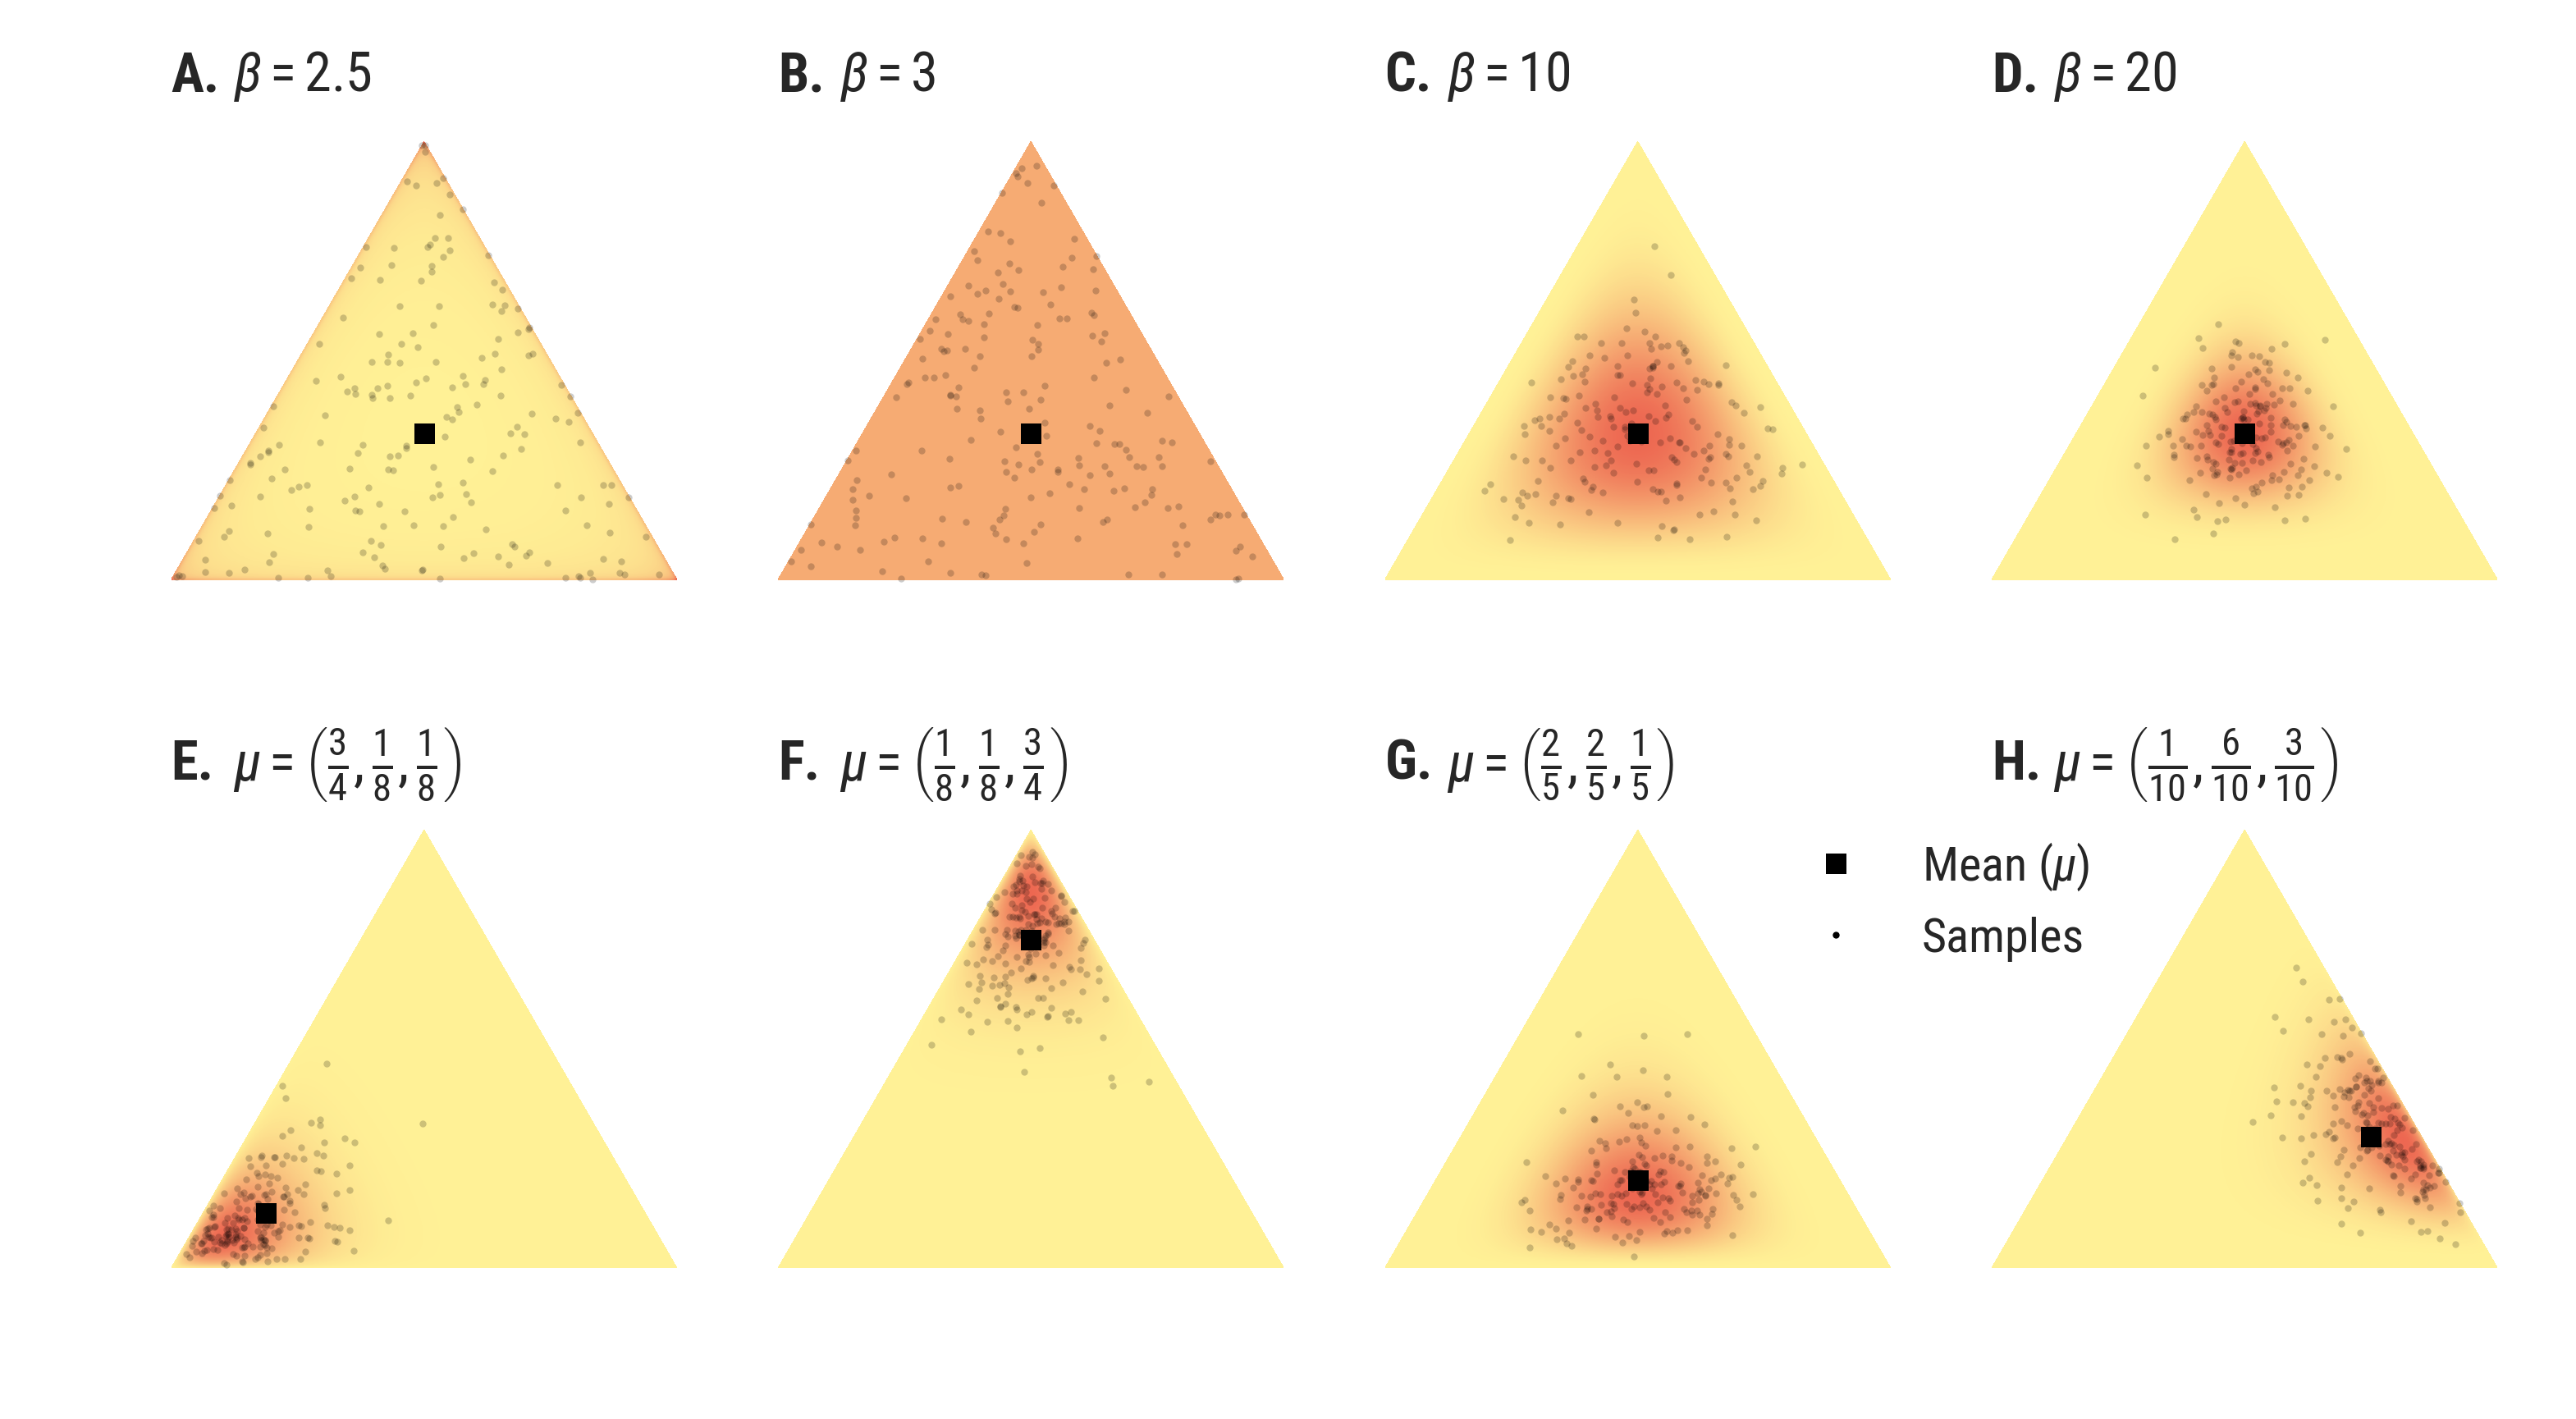

In [3]:
# Plot 
figure(figsize=cm2inch(12,6))
pis = array([[.33,.33,.33], [1,1,1], [1,1,1], [1,1,1],
             [6,1,1], [1,1,6], [4,4,2], [2,12,6]])
betas = [2.5, 3, 10, 20, 15, 15, 15, 15]
titles = ([r'$\beta={}$'.format(beta) for beta in betas[:4]]
        +[r'$\mu=\left(\frac{3}{4},\frac{1}{8},\frac{1}{8}\right)$', 
          r'$\mu=\left(\frac{1}{8},\frac{1}{8},\frac{3}{4}\right)$',
          r'$\mu=\left(\frac{2}{5},\frac{2}{5},\frac{1}{5}\right)$',
          r'$\mu=\left(\frac{1}{10},\frac{6}{10},\frac{3}{10}\right)$'])

ax1 = subplot(241);
ax2 = subplot(242)
ax3 = subplot(243)
ax4 = subplot(244)
ax5 = subplot(245)
ax6 = subplot(246)
ax7 = subplot(247)
ax8 = subplot(248)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for titl, pi, beta, ax in zip(titles, pis, betas, axes):
    sca(ax)
    alpha = pi/pi.sum() * beta
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist, cmap=CustomCmap('yellow', 'orange'))
    title(titl)
    
    # Plot some samples
    plot_points(dist.sample(200), border=False, lw=0, ms=1, marker='o', alpha=.2)
    
    # Plot
    plot_points(array([alpha])/alpha.sum(), border=False, color='k', lw=0, ms=3, marker='s')


plot(-10,0, color='k', lw=0, ms=3, marker='s', label='Mean ($\mu$)')
plot(-10,0, 'k', lw=0, ms=1, marker='o', label='Samples')
xlim(0,1)

restyle_title(*axes,y=1.1)

legend(bbox_to_anchor=(0.25,1))
subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=.45)
savefig('FIG02-dirichlet-parameters.png', dpi=450, bbox_inches='tight')
copyfig('FIG02-dirichlet-parameters.png')

# Jensen-Shannon divergence

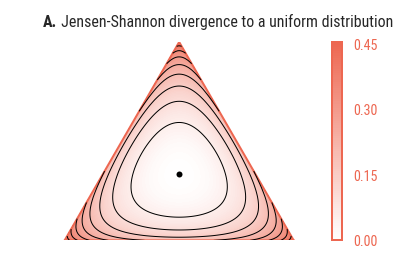

In [5]:
#Plot 
from matplotlib import ticker

subdiv=7
refiner = tri.UniformTriRefiner(_triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)
pvals = [JSD(join(xy2bc(xy), ones(3)/3, cols=3)) for xy in zip(trimesh.x, trimesh.y)]


figure(figsize=cm2inch(6,3.5))
c = plt.tricontourf(trimesh, pvals, 100, cmap=CustomCmap('white', 'orange'))
plt.tricontour(trimesh, pvals, 10, colors='k',linewidths=.5)
plt.triplot(_triangle, linewidth=1, color='#ed6751')

cb = colorbar(c)#, fraction=0.0295)
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

title(r'Jensen-Shannon divergence to a uniform distribution')
plot(.5,sqrt(3)/6, 'o')
restyle_title(gca(), y=1.1)
axis('off');
axis('equal');

subplots_adjust(left=0, bottom=0, right=1, top=1)
savefig('FIG02-JSD.png', dpi=450, bbox_inches='tight')
copyfig('FIG02-JSD.png')

# Exaggeration

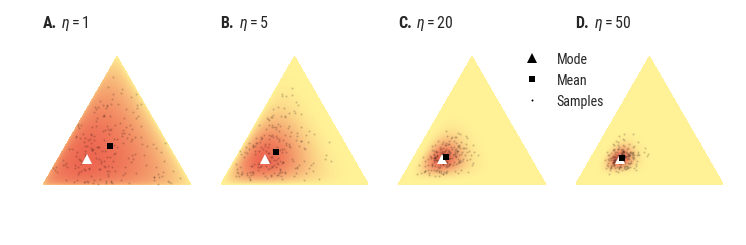

In [6]:
# plot
figure(figsize=cm2inch(12,3))
pi = np.array([.4,.3,.3])
alpha = pi * 4

def plotDir(eta):
    _alpha = eta*(alpha-1)+1
    dist = Dirichlet(_alpha)
    draw_pdf_contours(dist, cmap=CustomCmap('yellow', 'orange'))
    title(r'$\eta={}$'.format(eta))
    
    # Samples
    plot_points(dist.sample(200), border=False, lw=0, ms=1, marker='o', alpha=.2)

    # Plot the mode
    mode = array([_alpha - 1])/(_alpha - 1).sum()
    plot_points(mode, border=False, lw=0, ms=5, 
                marker='^', markerfacecolor='white')
    
    # Plot the mean
    mean = array([_alpha])/(_alpha).sum()
    plot_points(mean, border=False, color='k', lw=0, ms=3, marker='s')

ax1 = subplot(141)
plotDir(1)

ax2 = subplot(142)
plotDir(5)

ax3 = subplot(143)
plotDir(20)

ax4 = subplot(144)
plotDir(50)

restyle_title(ax1,ax2,ax3,ax4)

# Legend
plot(-10,0, color='k', lw=0, ms=5, marker='^',markerfacecolor='k', label='Mode')
plot(-10,0, 'k', lw=0, ms=3, marker='s', label='Mean')
plot(-10,0, 'k', lw=0, ms=1, marker='o', label='Samples')
xlim(0,1)
legend(bbox_to_anchor=(0.25,.95))

subplots_adjust(left=0, bottom=0, right=1, top=1)
savefig('FIG02-dirichlet-eta.png', dpi=450, bbox_inches='tight')
copyfig('FIG02-dirichlet-eta.png')

In [7]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

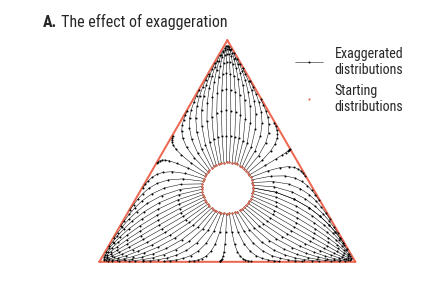

In [8]:
# Plot
figure(figsize=cm2inch(6.5,4))
subdiv=7
refiner = tri.UniformTriRefiner(_triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)

# Equidistant points on a circle
phis= linspace(0,2*np.pi,60)
xs, ys = pol2cart(.1,phis)
points=array([xs+.5, ys+sqrt(3)/6]).T
points = [xy2bc(p) for p in points]

for i,p in enumerate(points):
    p=array(p)
    path = [p**zeta / sum(p**zeta) for zeta in arange(1,10)]
    plot_points(array(path), color='k', border=False, 
                lw=.25, ms=1, marker='o')

plot_points(array(points), lw=0, marker='o', ms=1.1, color='#ed6751', border=False) 

plt.triplot(_triangle, linewidth=1, color='#ed6751')
title(r'The effect of exaggeration')
restyle_title(gca())
plot(-10,0, color='k', lw=.25, ms=1, marker='o', label='Exaggerated\ndistributions')
plot(-10,0, 'k', lw=0, marker='o', ms=1.1, color='#ed6751', label='Starting\ndistributions')
legend()
ylim(-0.01,ylim()[1]+.01)

subplots_adjust(left=0, bottom=0, right=1, top=1)
savefig('FIG02-exaggerated-categoricals.png', dpi=450, bbox_inches='tight')
copyfig('FIG02-exaggerated-categoricals.png')

# Exaggerating words

In [9]:
eta=2
f = lambda thetas: sum(thetas**eta)
subdiv=7
refiner = tri.UniformTriRefiner(_triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)
fvals = [f(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

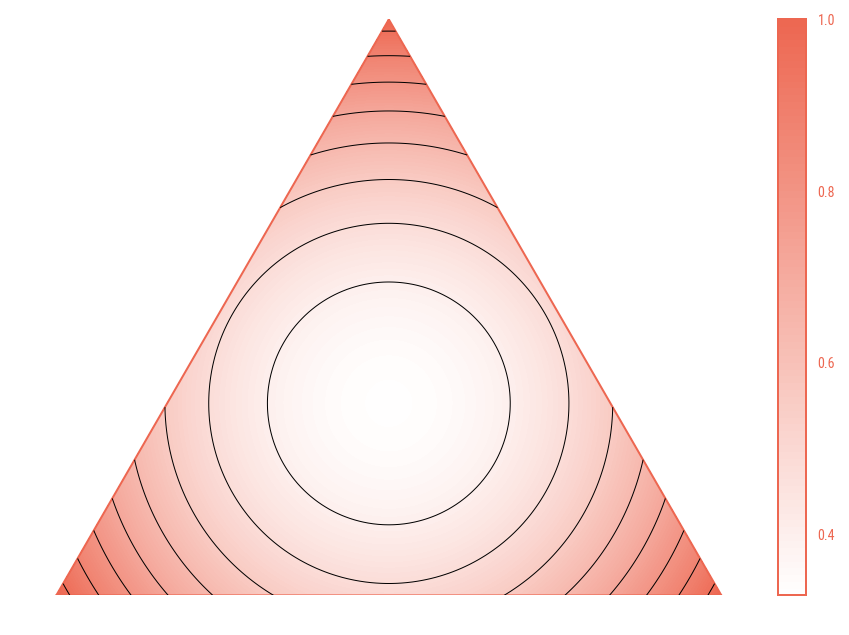

In [11]:
#plot
from matplotlib import ticker
# figure(figsize=6,3.5))
c = plt.tricontourf(trimesh, fvals, 100, cmap=CustomCmap('white', 'orange'))
plt.tricontour(trimesh, fvals, 10, colors='k',linewidths=.5)
plt.triplot(_triangle, linewidth=1, color='#ed6751')

cb = colorbar(c)#, fraction=0.0295)
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

# plot(.5,sqrt(3)/6, 'o')
# restyle_title(gca(), y=1.1)
axis('off');
axis('equal');

subplots_adjust(left=0, bottom=0, right=1, top=1)


# Posterior with $\zeta=\infty$

In [12]:
def posterior_pvals(dist, x, trimesh):
    thetas = array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    pvals = array([prior.pdf(theta) for theta in thetas])
    pvals = pvals * (thetas.argmax(axis=1) == x)
    return pvals / pvals.sum()

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


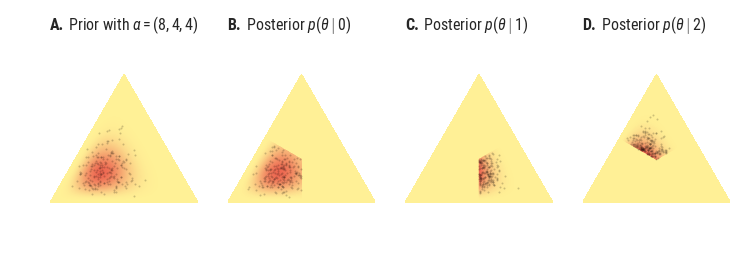

In [15]:
#Plot
figure(figsize=cm2inch(12,3.5))
alpha = np.array([8, 4, 4])
prior = Dirichlet(alpha)

# Trimesh et
subdiv=8
refiner = tri.UniformTriRefiner(_triangle)
trimesh = refiner.refine_triangulation(subdiv=subdiv)

def plot_posterior(x):
    pvals = posterior_pvals(prior, x, trimesh)
    samples = prior.sample(2000)
    samples = samples[samples.argmax(axis=1) == x, :][:200,:]
    c = plt.tricontourf(trimesh, pvals, 100, cmap=CustomCmap('yellow', 'orange'))
    plot_points(samples, border=False, lw=0, ms=1, marker='o', alpha=.2)
    title(r'Posterior $p(\theta \mid {})$'.format(x))

ax1 = subplot(141)
draw_pdf_contours(prior, cmap=CustomCmap('yellow', 'orange'))
plot_points(prior.sample(200), border=False, lw=0, ms=1, marker='o', alpha=.2)
title(r'Prior with $\alpha=(8,4,4)$')

ax2 = subplot(142)
plot_posterior(0)

ax3 = subplot(143)
plot_posterior(1)

ax4 = subplot(144)
plot_posterior(2)

restyle_title(ax1, ax2, ax3, ax4)
axis('off');
axis('equal');
subplots_adjust(left=0, bottom=0, right=1, top=1)

subplots_adjust(left=0, bottom=0, right=1, top=1)
savefig('FIG02-posterior-zeta-infty.png', dpi=450, bbox_inches='tight')
copyfig('FIG02-posterior-zeta-infty.png')